In [1]:
import numpy as np
#from scipy import interpolate
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize

np.random.seed(1)
%load_ext autotime
%matplotlib inline

In [26]:
##
# Grids
##
#y_grid = 10+30*np.array([range(0,50)]).reshape(50)
#state_grid = np.array([200,250])
#b_grid = 5*np.array(range(0,100))

y_grid = 5000 + 5000*np.arange(600)
#check if required
y_grid = y_grid.reshape(600)
b_grid = 20000 + 5000*np.arange(0,200)
#lyg = len(y_grid) NOT BEING USED

#lbg = len(b_grid)

3 µs ± 252 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
[  20000   25000   30000   35000   40000   45000   50000   55000   60000
   65000   70000   75000   80000   85000   90000   95000  100000  105000
  110000  115000  120000  125000  130000  135000  140000  145000  150000
  155000  160000  165000  170000  175000  180000  185000  190000  195000
  200000  205000  210000  215000  220000  225000  230000  235000  240000
  245000  250000  255000  260000  265000  270000  275000  280000  285000
  290000  295000  300000  305000  310000  315000  320000  325000  330000
  335000  340000  345000  350000  355000  360000  365000  370000  375000
  380000  385000  390000  395000  400000  405000  410000  415000  420000
  425000  430000  435000  440000  445000  450000  455000  460000  465000
  470000  475000  480000  485000  490000  495000  500000  505000  510000
  515000  520000  525000  530000  535000  540000  545000  550000  555000
  560000  565000  570000  575000  580000  585000  590

In [3]:
##
# Parameters
##
beta = 0.95
alpha = 10
w = np.array([0,0.5,1])
param = np.append(alpha,w)
J = len(w)

rho = np.ones(np.shape(w))/np.shape(w)
sigma=0.1
n_draws = 200
# distribution of own returns
#distr_R = np.array( np.random.uniform(0.95,1.05,n_draws) )
#distr_R = np.array( np.random.uniform(1,1,n_draws) )
#bidders / income distribution
N = 100
b = 0.1
#var_income = 1.2
#y_realis_1 = np.random.lognormal(np.log(200),np.log(var_income),np.round(N))

#y_realis_1 = np.array([np.random.lognormal(np.log(s),np.log(var_income),N) for s in state_grid])




time: 20 ms


# States

In [5]:
#import stock market level
df=pd.read_csv("simulation_data/avgsp.csv", sep=",")
state_grid = 200.0*np.array(range(2,11))

lsg = len(state_grid)

#assign states to S&P Data

#round S&P level to nearest grid point
df['state'] = [400+200*np.round((sp-400)/200,0) for sp in df['avgsp']]

#calculate return
df['return'] = [df['avgsp'][i+1]/df['avgsp'][i] for i in range(len(df)-1)] + ['NA']

df

,Unnamed: 0,season,avgsp,state,return
0,1,1992,448.303753,400.0,1.02887
1,2,1993,461.245832,400.0,1.08824
2,3,1994,501.945005,600.0,1.26093
3,4,1995,632.918330,600.0,1.2657
4,5,1996,801.083338,800.0,1.283
5,6,1997,1027.788335,1000.0,1.21391
6,7,1998,1247.644999,1200.0,1.1381
7,8,1999,1419.950002,1400.0,0.900377
8,9,2000,1278.490814,1200.0,0.830024
9,10,2001,1061.178324,1000.0,0.857186


time: 44.1 ms


## Transition Probabilities between States

For now assume transition probabilities according to relative frequency of each state, regardless of current state (conditional and unconditional probabilities are the same)

In [6]:
state_freq = np.array([np.sum(1*(df['state']==s))/(len(df)-1.00) for s in state_grid])

transition_probs = np.tile(state_freq,lsg).reshape(lsg,lsg)

time: 374 ms


## Distribution of Returns by State

For now assume expectations over returns are the same in all states.

In [9]:
#Realised returns in S&P Data
realis_sp_return = np.array([df['avgsp'][i+1]/df['avgsp'][i] for i in range(len(df)-1)])

#Individual Returns: one of the realised returns plus idiosyncratic noise

distr_mean_R = np.array(np.random.choice(realis_sp_return,size=n_draws,replace=True))


distr_R = distr_mean_R + np.random.uniform(-0.05,+0.05,n_draws)

distr_R_states = np.array([distr_R for s in state_grid])
print(distr_R_states)

[[0.69659459 1.16597018 1.14557732 ... 1.07842785 0.92565953 1.05494632]
 [0.69659459 1.16597018 1.14557732 ... 1.07842785 0.92565953 1.05494632]
 [0.69659459 1.16597018 1.14557732 ... 1.07842785 0.92565953 1.05494632]
 ...
 [0.69659459 1.16597018 1.14557732 ... 1.07842785 0.92565953 1.05494632]
 [0.69659459 1.16597018 1.14557732 ... 1.07842785 0.92565953 1.05494632]
 [0.69659459 1.16597018 1.14557732 ... 1.07842785 0.92565953 1.05494632]]
time: 12 ms


## Income Distribution by State

In [10]:
y_realis_1 = np.random.lognormal(np.log(150000),np.log(2),np.round(N))

state_grid_change = np.array([state_grid[i]/state_grid[0] for i in range(lsg)])

#mean wealth
#50% of wealth invested in the stock market
mean_wealth_state = np.array([75000 + state_grid_change[s]*75000 for s in range(lsg)])

y_realis_states = np.array([np.random.lognormal(np.log(mean_wealth_state[s]),np.log(2),np.round(N)) for s in range(lsg)])



time: 40.1 ms


The slowest run took 4.76 times longer than the fastest. This could mean that an intermediate result is being cached.
466 ms ± 212 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


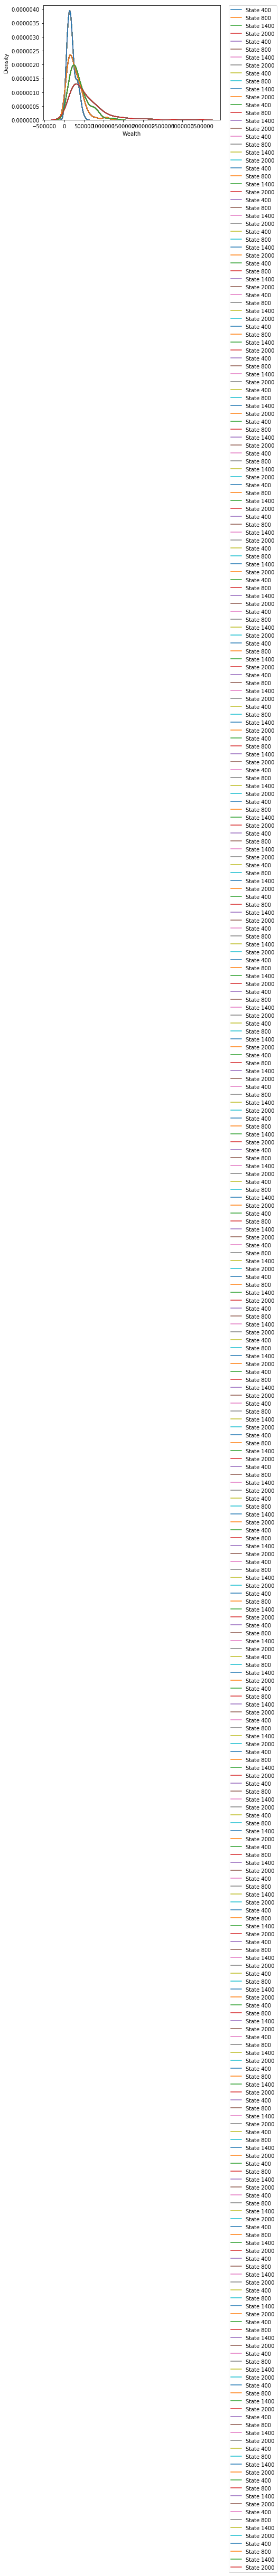

time: 41 s


In [20]:
fig, ax = plt.subplots()
for s in [0,2,5,8]: sns.distplot(y_realis_states[s,:],hist=False, label="State %d" %state_grid[s])
ax.set_xlabel("Wealth")
ax.set_ylabel("Density")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Bid Function

In [22]:
def bid_fn(f_param,f_set,f_B_next,f_S_next_interp,f_distr_R,f_transition_probs):
    (f_beta,f_rho,f_w,f_J,f_alpha) = (f_param[0],f_param[1],f_param[2],f_param[3],f_param[4])
    (f_y_grid,f_lyg,f_b_grid,f_n_draws,f_state_grid) = (f_set[0],f_set[1],f_set[2],f_set[3],f_set[4])
    (f_lyg,f_lbg,f_lsg) = (len(f_y_grid),len(f_b_grid),len(f_state_grid))
    distr_y_next_buy = f_beta * f_distr_R.reshape(f_lsg,1,f_n_draws,1) * (f_y_grid.reshape(1,f_lyg,1,1) - f_b_grid.reshape(1,1,1,f_lbg)) 
    ES_buy_per_state = np.array([[np.mean(f_S_next_interp[j,s](distr_y_next_buy[s,:,:,:]), axis=1) for s in range(f_lsg)] for j in range(f_J)]) 
    ES_buy = np.empty([f_J,f_lsg,f_lyg,f_lbg])
    for b in range(f_lbg):
        ES_buy[:,:,:,b] = np.array([np.dot(f_transition_probs,ES_buy_per_state[j,:,:,b]) for j in range(f_J)])
    error = (f_alpha/(1-f_beta)) * f_y_grid.reshape(1,1,f_lyg,1) * (f_w.reshape(f_J,1,1,1) + f_beta*(ES_buy - f_B_next.reshape(1,f_lsg,f_lyg,1))) - f_b_grid.reshape(1,1,1,f_lbg)
    return f_b_grid[np.argmin(error**2,axis=3)]

time: 40.1 ms


# Buyer Value Function

\begin{align*}
  B_{j}(y,s) =& \alpha \text{ln}((1-\beta) y) + (1-\sigma \textbf{Pr}[b_j(y,s)>\bar{b}_j])\cdot \beta \textbf{E}[B(y',s') | y,s] +\\
  &\sigma \cdot \int \Big( \textbf{1}(b_j(y,s)>\bar{b}_j) \big(w_j - \frac{\theta}{y} \bar{b}_j + \beta  \textbf{E}[S_j(y',s') | y-\bar{b}_j,s] \big) \Big) dG_{\bar{b}_j |s} \\
\end{align*}



In [23]:
def fn_B(f_param,f_set,f_B_next,f_S_next_interp,
         f_distr_R,f_transition_probs,
         bid_now,distr_b_bar_now):
    (f_beta,f_rho,f_w,f_J,f_alpha,f_sigma) = (f_param[0],f_param[1],f_param[2],f_param[3],f_param[4],f_param[5])
    (f_y_grid,f_lyg,f_b_grid,f_n_draws,f_state_grid) = (f_set[0],f_set[1],f_set[2],f_set[3],f_set[4])
    (f_lyg,f_lbg,f_lsg) = (len(f_y_grid),len(f_b_grid),len(f_state_grid))
    win_bool = (bid_now.reshape(f_J,f_lsg,f_lyg,1)>distr_b_bar_now.reshape(f_J,f_lsg,1,f_n_draws)) #dimensions: J x states x y_gridpoints x n_draws
    win_prob = np.mean(win_bool,axis=3) #dimensions: J x states x y_gridpoints
    #V1 = utility of composite good consumption plus continuation value of not winning (if inactive or active but losing the auction)
    V1 = (f_alpha*np.log((1-f_beta)*f_y_grid)).reshape(1,1,f_lyg) + (1-f_sigma*win_prob)*f_beta*f_B_next.reshape(1,f_lsg,f_lyg) #dimensions: J x states x y_gridpoints
    #distribution of wealth next period after buying
    distr_y_next_buy = f_beta * f_distr_R.reshape(1,f_lsg,1,f_n_draws,1) * (f_y_grid.reshape(1,1,f_lyg,1,1) - distr_b_bar_now.reshape(f_J,f_lsg,1,1,f_n_draws)) #dimensions: J x state_gridpoints x y_gridpoints x n_draws (R) x n_draws (b_bar)
    ES_buy_per_state = np.array([[np.mean(f_S_next_interp[j,s](distr_y_next_buy[j,s,:,:,:]), axis=1) for s in range(f_lsg)] for j in range(f_J)]) #dimesions: J x state_gridpoints x y_gridpoints x n_draws (b_bar)
    #Take expectations over tomorrow's state s' conditional on today's state s
    ES_buy = np.empty([f_J,f_lsg,f_lyg,f_n_draws]) #dimensions: J x states x y_gridpoints x n_draws (b_bar)
    for b in range(f_n_draws):
        ES_buy[:,:,:,b] = np.array([np.dot(f_transition_probs,ES_buy_per_state[j,:,:,b]) for j in range(f_J)]) 
    V2_per_b_bar = f_w.reshape(f_J,1,1,1) - (f_alpha*distr_b_bar_now.reshape(f_J,f_lsg,1,f_n_draws) / ((1-f_beta) * f_y_grid.reshape(1,1,f_lyg,1))) + f_beta*ES_buy #dimensions: J x states x y_gridpoints x n_draws (b_bar)
    V2 = f_sigma*np.mean(win_bool * V2_per_b_bar,axis=3)
    return V1 + V2

#Dimesions: J x state_gridpoints x y_gridpoints

time: 84.1 ms


# Seller Value Function

\begin{align*}
  S_{j}(y,s) =& \alpha \text{ln}((1-\beta) y) + (1-\rho_j)\cdot(w_j + \beta \textbf{E}[S_j(y',s') | y,s] ) + \\
  & \rho_j \cdot \int \Big( \text{max}\{ \frac{\theta}{y} b_{j,(2)} + \textbf{E}[B(y',s') | y+b_{j,(2)},s] ,\ w_j + \beta \textbf{E}[S_j(y',s') | y,s] \} \Big) dH_{b_{j,(2)} |s}
\end{align*}



In [24]:
def fn_S(f_param,f_set,f_B_next_interp,f_S_next_interp,
         f_distr_R,f_transition_probs,
         distr_b_2_now): #distribution of second highest bid among all active bidders
    (f_beta,f_rho,f_w,f_J,f_alpha,f_sigma) = (f_param[0],f_param[1],f_param[2],f_param[3],f_param[4],f_param[5])
    (f_y_grid,f_lyg,f_b_grid,f_n_draws,f_state_grid) = (f_set[0],f_set[1],f_set[2],f_set[3],f_set[4])
    (f_lyg,f_lbg,f_lsg) = (len(f_y_grid),len(f_b_grid),len(f_state_grid))
    distr_y_next = f_beta * f_distr_R.reshape(f_lsg,1,f_n_draws) * f_y_grid.reshape(1,f_lyg,1)  #dimensions: state_gridpoints x y_gridpoints x n_draws    
    ES_per_state = np.array([[np.mean(f_S_next_interp[j,s](distr_y_next[s,:,:]), axis=1) for s in range(f_lsg)] for j in range(f_J)]) #dimensions: J x state_gridpoints x y_gridpoints #take expectation over return R
    #take expectation over next state
    ES = np.array([np.dot(f_transition_probs,ES_per_state[j,:,:]) for j in range(f_J)]) #dimension: J x state_gridpoint x y_gridpoints
    #utility of keeping the car
    keep = (f_w.reshape(f_J,1,1) + ES) 
    V1 = (f_alpha*np.log((1-f_beta)*f_y_grid)).reshape(1,1,f_lyg) + (1-f_rho.reshape(f_J,1,1)) * keep
    #distribution of wealth next period after selling
    distr_y_next_sell = f_beta * f_distr_R.reshape(1,f_lsg,1,f_n_draws,1) * (f_y_grid.reshape(1,1,f_lyg,1,1) + distr_b_2_now.reshape(f_J,f_lsg,1,1,f_n_draws)) #dimensions: J x state_gridpoints x y_gridpoints x n_draws (R) x n_draws (b_2)
    EB_sell_per_state = np.array([[[np.mean(f_B_next_interp[k,s](distr_y_next_sell[j,s,:,:,:]), axis=1) for s in range(f_lsg)] for j in range(f_J)] for k in range(f_J)]) #take expectation over return R #dimesions: J x state_gridpoints x y_gridpoints x n_draws (b_2) 
    #Take expectations over tomorrow's state s' conditional on today's state s
    EB_sell = np.empty([f_J,f_lsg,f_lyg,f_n_draws])
    for b in range(f_n_draws):
        EB_sell[:,:,:,b] = np.array([np.sum([f_rho[k]*np.dot(f_transition_probs,EB_sell_per_state[k,j,:,:,b]) for k in range(f_J)], axis=0) for j in range(f_J)])
    #utility of selling the car
    sell_per_b_2 = (f_alpha*distr_b_2_now.reshape(f_J,f_lsg,1,f_n_draws) / ((1-f_beta) * f_y_grid.reshape(1,1,f_lyg,1))) + f_beta*EB_sell #dimensions: J x states x y_gridpoints x n_draws (b_bar)
    sell = np.mean(sell_per_b_2,axis=3)
    V2 = f_rho.reshape(f_J,1,1) * np.max([keep,sell],axis=0)
    return V1 + V2


time: 116 ms


# Iterate

In [25]:
def fn_iterate(f_param,f_set,
               B_start,S_start,n_iter,
              f_distr_R,f_transition_probs,
              f_y_realis,f_rival_bidders_ids,f_active_bidders_ids):
    (f_beta,f_rho,f_w,f_J,f_alpha,f_sigma) = (f_param[0],f_param[1],f_param[2],f_param[3],f_param[4],f_param[5])
    (f_y_grid,f_lyg,f_b_grid,f_n_draws,f_state_grid) = (f_set[0],f_set[1],f_set[2],f_set[3],f_set[4])
    (f_lyg,f_lbg,f_lsg) = (len(f_y_grid),len(f_b_grid),len(f_state_grid))
    check = []
    bids_iter = []
    (B1,S1) = (B_start,S_start)
    #
    for t in range(n_iter):
        B1_interp = np.array([[interp1d(y_grid,B1[j,s,:],fill_value='extrapolate') for s in range(f_lsg)] for j in range(f_J)]) #one function for each car j and each state s
        S1_interp = np.array([[interp1d(y_grid,S1[j,s,:],fill_value='extrapolate') for s in range(f_lsg)] for j in range(f_J)]) 
        #initial expected continuation value as buyer
        distr_y_next = beta * f_distr_R.reshape(f_lsg,1,f_n_draws) * f_y_grid.reshape(1,f_lyg,1) #dimensions: state_gridpoints x y_gridpoints x n_draws
        EB_per_state_1 = np.array([[np.mean(B1_interp[j,s](distr_y_next[s,:,:]), axis=1) for s in range(f_lsg)] for j in range(J)]) 
        EB1 = np.sum([f_rho[j]*np.dot(f_transition_probs,EB_per_state_1[j,:,:]) for j in range(f_J)],axis=0) #dimension: state_gridpoint x y_gridpoints
        #bid function
        bid1 = bid_fn(f_param,f_set,EB1,S1_interp,f_distr_R,f_transition_probs)
        #distribution of highest rival bid
        distr_bids1 = np.array([[np.interp(f_y_realis[s,:],f_y_grid,bid1[j,s,:]) for s in range(f_lsg)] for j in range(f_J)])
        distr_b_bar_1 = np.array([[[np.sort(distr_bids1[j,s,f_rival_bidders_ids[i]])[-1] for i in range(f_n_draws)] for s in range(f_lsg)] for j in range(f_J)])
        #next iteration of buyer value function
        B2 = fn_B(f_param,f_set,EB1,S1_interp,f_distr_R,f_transition_probs,bid1,distr_b_bar_1)
        #distribution of 2nd highest bid (sale price)
        distr_b_2 = np.array([[[np.sort(distr_bids1[j,s,f_active_bidders_ids[i]])[-2] for i in range(f_n_draws)] for s in range(f_lsg)] for j in range(f_J)])
        #next iteration of seller value function
        S2 = fn_S(f_param,f_set,B1_interp,S1_interp,f_distr_R,f_transition_probs,distr_b_2)
        check = check + [np.max(np.absolute(B2-B1))]
        bids_iter = bids_iter + [bid1]
        (B1,S1) = (B2,S2)
    return [check,bids_iter,B1,S1]


time: 140 ms


# Initialize

Initialize Buyer value to $B_{j}(y,s) = \frac{1}{1-\beta} \alpha \text{ln}((1-\beta)y)$

And seller value to $S_j(y,s)= \frac{1}{1-\beta}(\alpha \text{ln}((1-\beta)y) + w_j)$

In [26]:
B1 = (1/(1-beta))*  (alpha*np.log((1-beta)*y_grid) + np.zeros(len(w)*state_grid.shape[0]*len(y_grid)).reshape(len(w),state_grid.shape[0],len(y_grid)))
S1 = (1/(1-beta))* (alpha*np.log((1-beta)*y_grid) + np.array(np.repeat(w,state_grid.shape[0]*len(y_grid))).reshape(len(w),state_grid.shape[0],len(y_grid)))

time: 8.01 ms


# Run

In [27]:
%%time

#initial value functions
B_cont = B1
S_cont = S1

#every one of N potential bidders has probability sigma of being active -- if m bidders are active, there are m-1 rivals
rival_bidders = np.random.binomial(N,sigma,size=n_draws) - 1
rival_bidders_ids = np.array([np.random.choice(N,size=rival_bidders[i], replace=False) for i in range(n_draws)]) #dimensions: n_draws

#every one of N potential bidders has probability sigma of being active
active_bidders = np.random.binomial(N,sigma,size=n_draws)
active_bidders_ids = np.array([np.random.choice(N,size=active_bidders[i], replace=False) for i in range(n_draws)])
#dimensions: n_draws

param1 = [beta,rho,w,J,alpha,sigma]
set1 = [y_grid,lyg,b_grid,n_draws,state_grid]    

sim_output = fn_iterate(f_param = param1,f_set = set1,
                    B_start = B_cont,S_start = S_cont, n_iter = 2,
                    f_distr_R = distr_R_states,f_transition_probs = transition_probs,
                    f_y_realis = y_realis_states,
                    f_rival_bidders_ids=rival_bidders_ids, f_active_bidders_ids = active_bidders_ids)

#check,bids_iter,B1,S1

Wall time: 16min 47s
time: 17min 4s


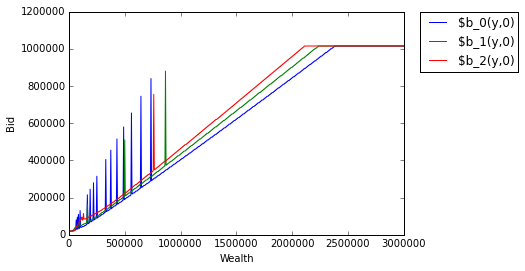

In [24]:
fig, ax = plt.subplots()
for j in [0,1,2]:
    ax.plot(y_grid,sim_output[1][1][j,0,:], label="$b_%d(y,0)" %j)
#for j in [1,2]:
#    ax.plot(y_grid,sim_output[1][1][j,4,:], label="$b_%d(y,8)" %j)
#for j in [1,2]:
#    ax.plot(y_grid,sim_output[1][1][j,8,:], label="$b_%d(y,8)" %j)
ax.set_xlabel("Wealth")
ax.set_ylabel("Bid")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [26]:
distr_bids1 = np.array([[np.interp(y_realis_states[s,:],y_grid,sim_output[1][1][j,s,:]) for s in range(lsg)] for j in range(J)])
distr_b_2 = np.array([[[np.sort(distr_bids1[j,s,active_bidders_ids[i]])[-2] for i in range(n_draws)] for s in range(lsg)] for j in range(J)])

In [27]:
distr_b_2.shape

(3, 9, 200)

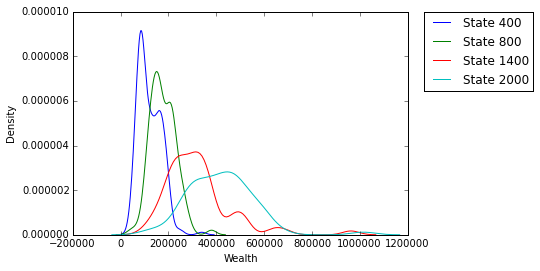

In [28]:
fig, ax = plt.subplots()
for s in [0,2,5,8]:
    sns.distplot(distr_b_2[1,s,:],hist=False, label="State %d" %state_grid[s])
ax.set_xlabel("Wealth")
ax.set_ylabel("Density")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

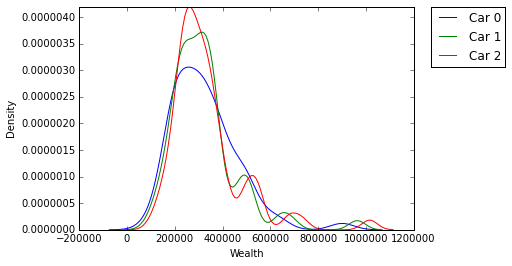

In [29]:
fig, ax = plt.subplots()
for j in [0,1,2]:
    sns.distplot(distr_b_2[j,5,:],hist=False, label="Car %d" %j)
ax.set_xlabel("Wealth")
ax.set_ylabel("Density")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [30]:
E_price = np.mean(distr_b_2,axis=2)

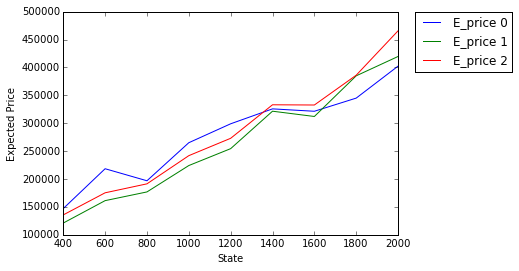

In [35]:
fig, ax = plt.subplots()
for j in [0,1,2]:
    ax.plot(state_grid,E_price[j,:], label="E_price %d" %j)
ax.set_xlabel("State")
ax.set_ylabel("Expected Price")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)